In [ ]:
import os

## MUST SET YOUR OWN OPENAI API KEY HERE
os.environ["OPENAI_API_KEY"] = '...'

import numpy as np
import pandas as pd
import random

import textwrap
import matplotlib.pyplot as plt
import seaborn as sns

from llm_scores_analysis import * ### all important analysis functions stored here

In [2]:
from openai import Client
client = Client(api_key=os.environ["OPENAI_API_KEY"])


# Set Up

In [3]:
current_dir = os.getcwd()
if current_dir.endswith("notebooks"):
    prefix = "../"
else:
    prefix = "./"

base_dir = os.path.join(prefix, "summeval-data")
print(base_dir)

full_df = pd.read_json(os.path.join(base_dir, "summeval_processed_full.jsonl"), lines=True)


../summeval-data


In [4]:
N_SUBSET = 300

selected_df = full_df.sample(n=N_SUBSET, random_state=42)
print(len(selected_df))

selected_indices = selected_df.index
print(selected_indices)

300
Index([ 526,  354,  168,  135,  937, 1544, 1253,  237,  478,  650,
       ...
        163, 1296,  266, 1005,  873,  692, 1450, 1263,  192,  548],
      dtype='int64', length=300)


In [5]:
models = [
    "gpt-4o-mini-2024-07-18",
    "gpt-3.5-turbo",
    "mistral-small-latest",
    "mistral-medium-latest",
    "claude-3-5-haiku-20241022"
]

In [6]:
output_dir = "../results/og"  ### Change as needed
score_tables = {}
explain_tables = {}

for model in models:

    score_path = os.path.join(output_dir, f"score_table_{model}.npy")
    explain_path = os.path.join(output_dir, f"explain_table_{model}.npy")

    score_tables[model] = np.load(score_path, allow_pickle=True)
    explain_tables[model] = np.load(explain_path, allow_pickle=True)

    print(f"{model} → Scores shape: {score_tables[model].shape}, Explains shape: {explain_tables[model].shape}")
    
    if np.all(score_tables[model] != -1) and score_tables[model].size > 0 and explain_tables[model].size > 0:
        print(f"[OK]: Scores & explanations loaded successfully.\n")
    else:
        print(f"[WARN]: Missing or invalid data.\n")

gpt-4o-mini-2024-07-18 → Scores shape: (300, 14, 1), Explains shape: (300, 14, 1)
[OK]: Scores & explanations loaded successfully.

gpt-3.5-turbo → Scores shape: (300, 14, 1), Explains shape: (300, 14, 1)
[OK]: Scores & explanations loaded successfully.

mistral-small-latest → Scores shape: (300, 14, 1), Explains shape: (300, 14, 1)
[OK]: Scores & explanations loaded successfully.

mistral-medium-latest → Scores shape: (300, 14, 1), Explains shape: (300, 14, 1)
[OK]: Scores & explanations loaded successfully.

claude-3-5-haiku-20241022 → Scores shape: (300, 14, 1), Explains shape: (300, 14, 1)
[OK]: Scores & explanations loaded successfully.



In [7]:
properties_og = ["fluency", "relevance", "coherence", "consistency"]

assertion_dictionary_og = {
    'fluency': {
        'C1-A1': 'Fluency measures the quality of individual sentences, are they well-written and grammatically correct. Consider the quality of individual sentences.',
        'C1-A2': 'Each sentence is free from grammatical errors and awkward phrasing.',
        'C1-A3': 'Contains sentences that are incomplete or lack a clear subject-verb-object structure',
        # 'C1-A3': 'Sentences contains grammatical errors and awkward phrasing.', ### negation example
    },
    'relevance': {
        'C2-A1': 'Relevance measures how well the summary captrues the key points of the article. Consider whether all and only the important aspects are contained in the summary.',
        'C2-A2': 'Contains no irrelevant or extraneous information unrelated to the article\'s main points',
        'C2-A3': 'Includes all context necessary for understanding key events or claims',
        'C2-A4': 'Includes absolutely all information that could reasonably be necessary to evaluate events or claims, even if not central to the article’s key points.',
        'C2-A5': 'Includes at least some information needed to understand key events or claims.',
    },
    'coherence': {
        'C3-A1': 'Coherence measures the quality of all sentences collectively, to the fit togheter and soound naturally. Consider the quality of the summary as a whole.',
        'C3-A2': 'Sentences in the summary logically progress from one to another without introducing conflicting or unrelated information.',
        'C3-A3': 'Maintains logical progression without conflicting or contradictory information',
    },
    'consistency': {
        'C4-A1': "Consistency measures whether the facts in the summary are consistent with the facts in the original article. COnsider whether the summary does reproduce all facts accurately and does not make up untrue information.",
        'C4-A2': 'The summary includes no fabricated details or misrepresented facts compared to the original article.',
        'C4-A3': 'Summary contains only verifiable facts directly present in the original article.',
    }
}

In [8]:
### Change as needed

properties = properties_og
assertion_dictionary = assertion_dictionary_og

In [9]:
def _build_assertion_labels(assertion_dictionary):
    assertion_labels = []
    wrapped_labels = []
    for prop, assertions in assertion_dictionary.items():
        for a_id, assertion_text in assertions.items():
            label = f"{prop.capitalize()} - {a_id}"
            wrapped = textwrap.fill(assertion_text, width=50)
            full_label = f"{label}\n{wrapped}"
            assertion_labels.append(label)
            wrapped_labels.append(full_label)
    return assertion_labels, wrapped_labels

assertion_labels, wrapped_labels = _build_assertion_labels(assertion_dictionary)
print(assertion_labels)
print(wrapped_labels)

['Fluency - C1-A1', 'Fluency - C1-A2', 'Fluency - C1-A3', 'Relevance - C2-A1', 'Relevance - C2-A2', 'Relevance - C2-A3', 'Relevance - C2-A4', 'Relevance - C2-A5', 'Coherence - C3-A1', 'Coherence - C3-A2', 'Coherence - C3-A3', 'Consistency - C4-A1', 'Consistency - C4-A2', 'Consistency - C4-A3']
['Fluency - C1-A1\nFluency measures the quality of individual\nsentences, are they well-written and grammatically\ncorrect. Consider the quality of individual\nsentences.', 'Fluency - C1-A2\nEach sentence is free from grammatical errors and\nawkward phrasing.', 'Fluency - C1-A3\nContains sentences that are incomplete or lack a\nclear subject-verb-object structure', 'Relevance - C2-A1\nRelevance measures how well the summary captrues\nthe key points of the article. Consider whether\nall and only the important aspects are contained\nin the summary.', "Relevance - C2-A2\nContains no irrelevant or extraneous information\nunrelated to the article's main points", 'Relevance - C2-A3\nIncludes all contex

# 1. Score Configurations and Distributions

## 1.1 Average across all models


=== Across Models ===
avg_rating_per_assertion:
 [0.38266667 0.24       0.57533333 0.64533333 0.70533333 0.51066667
 0.15666667 0.89133333 0.46133333 0.62       0.71533333 0.76733333
 0.77866667 0.80933333]


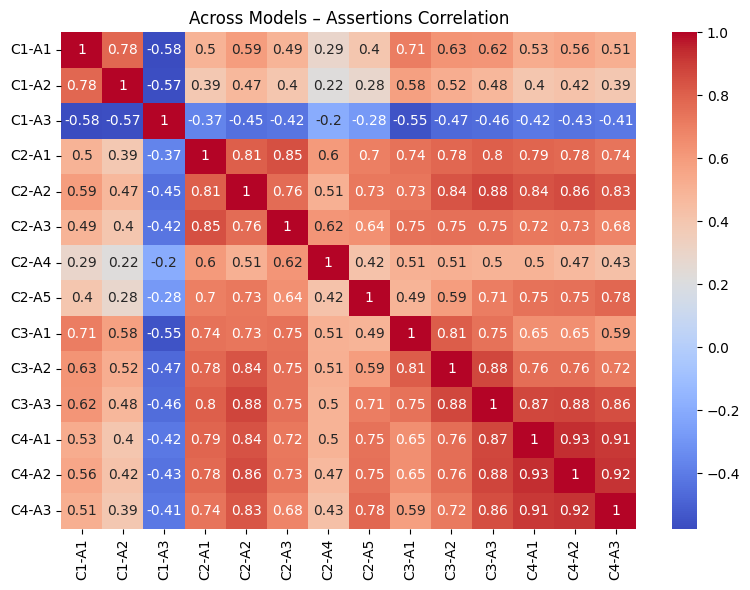

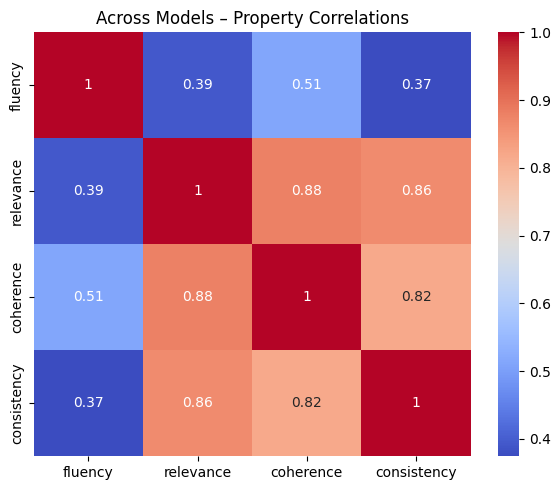

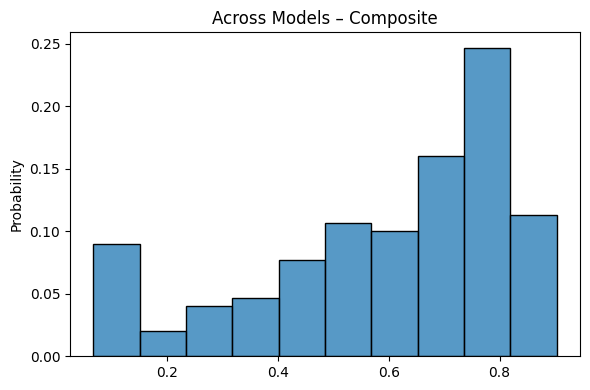

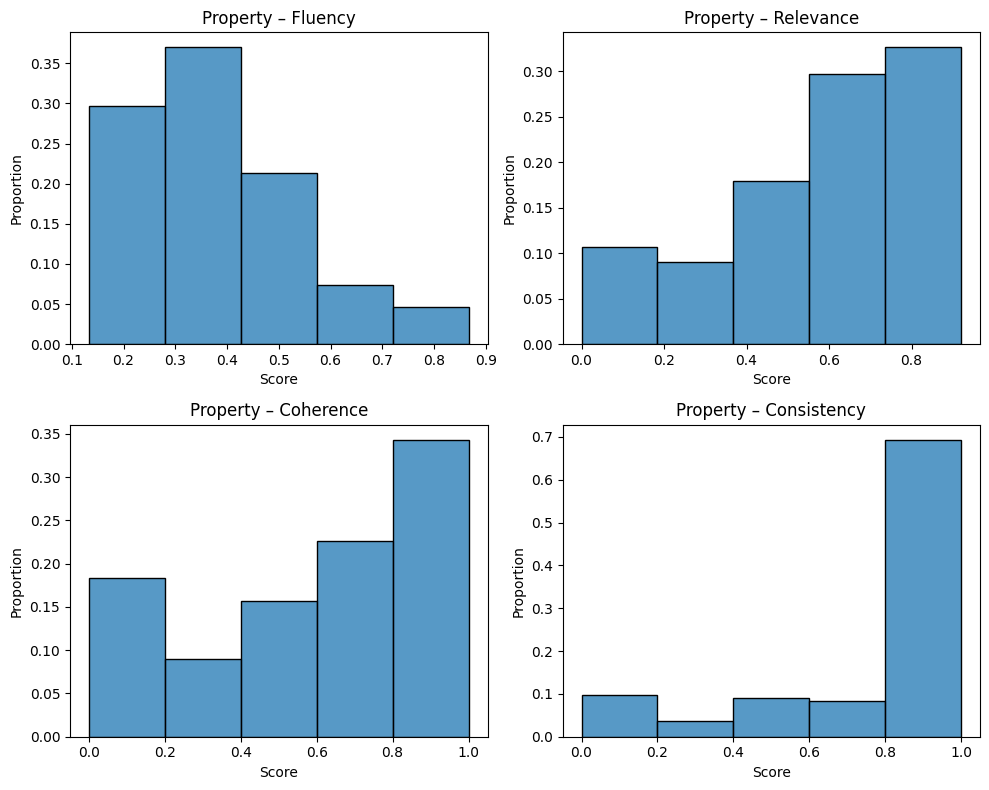

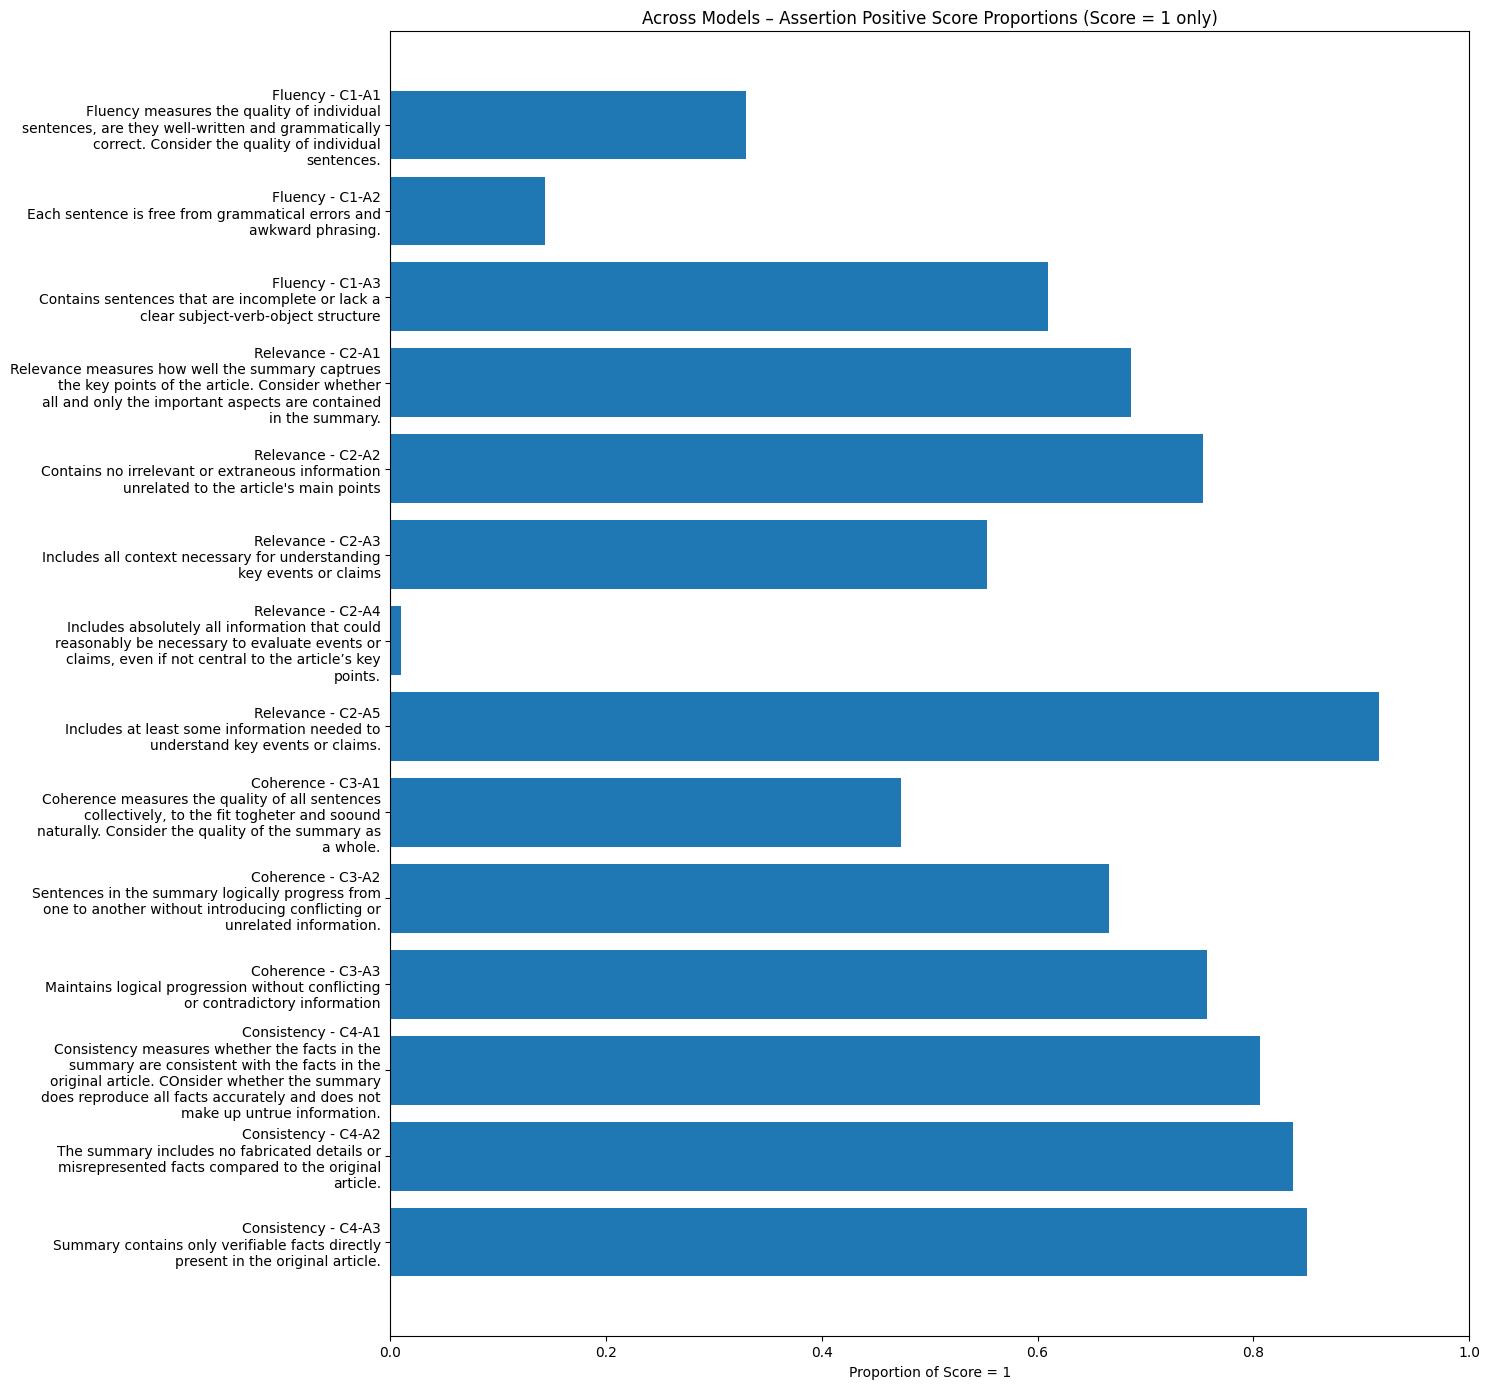

variance_per_assertion:
 [0.14533333 0.11573333 0.1752     0.1096     0.0984     0.14666667
 0.10933333 0.0504     0.12053333 0.09546667 0.08106667 0.0768
 0.07306667 0.0552    ] (14,)


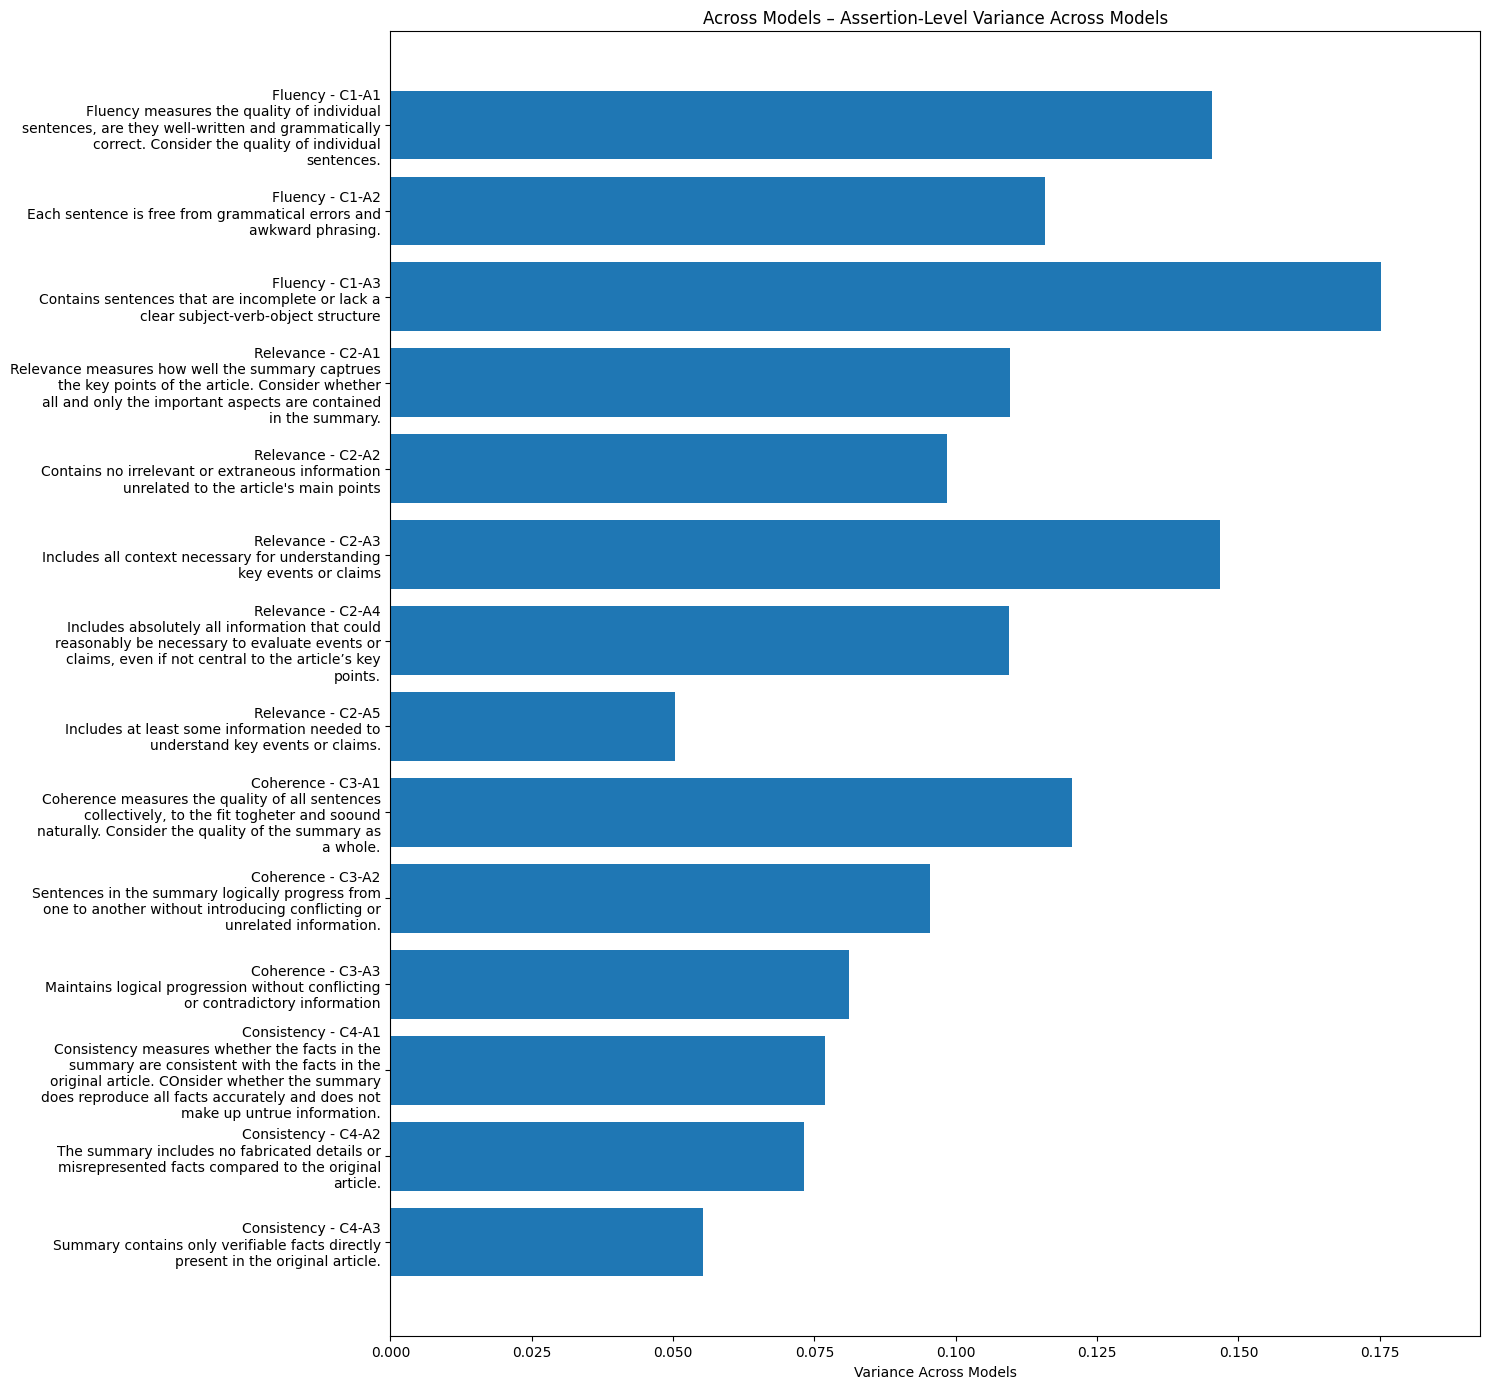

avg_scores_per_assertion shape: (5, 14)


In [ ]:
cross_report = analyze_across_models(
    score_tables=score_tables,
    explain_tables=explain_tables,
    properties=properties,
    assertion_dictionary=assertion_dictionary
)

In [47]:
cross_report.keys()

dict_keys(['model_scores', 'avg_across_models', 'avg_rating_per_assertion', 'property_scores_avg_models', 'property_corr_avg_models', 'composite_scores', 'model_variance', 'variance_per_assertion', 'avg_scores_per_assertion'])

In [33]:
# model_scores = np.stack([score_tables[m].mean(axis=2)  # reduce judges first for stability
#                              for m in score_tables], axis=0)  # (models, items, assertions)
# print(model_scores.shape)

# avg_across_models = np.mean(model_scores, axis=0)  ### shape: (300, n_assertions)
# avg_across_models = avg_across_models.squeeze()
# print(avg_across_models.shape)

# avg_score_df = pd.DataFrame(avg_across_models, columns=assertion_labels)
# correlation_of_averages = avg_score_df.corr(method="pearson")

# assertion_keys = [assertion_id
#     for prop_dict in assertion_dictionary.values()
#     for assertion_id in prop_dict.keys()
# ]

# sns.heatmap(correlation_of_averages, annot=True, cmap="coolwarm", xticklabels=assertion_keys, yticklabels=assertion_keys)
# plt.title("Average Assertion Correlation Across Models")
# plt.show()



In [34]:
# avg_rating_per_assertion = avg_across_models.mean(axis=0)  # shape: (num_assertions,)

In [35]:
# def _property_index_map(assertion_dictionary):
#     """Map each property to its global assertion column indices (0..num_assertions-1)."""
#     prop_to_inds = {}
#     global_index = 0
#     for prop in properties:
#         if prop in assertion_dictionary:
#             prop_to_inds[prop] = []
#             for _ in assertion_dictionary[prop].values():
#                 prop_to_inds[prop].append(global_index)
#                 global_index += 1
#     return prop_to_inds

# property_to_assertions = _property_index_map(assertion_dictionary)
# print(property_to_assertions)

In [36]:
# property_scores = {} # dict of prop: (300,)

# for prop, indices in property_to_assertions.items():
#     prop_scores = avg_across_models[:, indices].mean(axis=1) # (300,)
#     property_scores[prop] = prop_scores

# property_scores['fluency'].shape


In [37]:
# avg_scores_per_assertion = model_scores.mean(axis=1)
# print(avg_scores_per_assertion.shape)

# composite_scores = np.vstack(list(property_scores.values())).mean(axis=0) # avg across all props (300,1)
# print(composite_scores.shape)


In [38]:
# property_matrix = np.stack([v for v in property_scores.values()], axis=1)
# property_corr = np.corrcoef(property_matrix.T)

# sns.heatmap(property_corr, annot=True, cmap="coolwarm", xticklabels=property_scores.keys(), yticklabels=property_scores.keys())
# plt.title("Property Correlations")
# plt.show()

In [39]:
# print("Composite")
# sns.histplot(composite_scores, bins=10, stat="probability")


In [40]:
# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
# axes = axes.flatten()

# for i, prop in enumerate(properties):
#     sns.histplot(property_scores[prop], bins=5, stat="probability", ax=axes[i])
#     axes[i].set_title(f'Property - {prop.capitalize()}')
#     axes[i].set_xlabel('Score')
#     axes[i].set_ylabel('Proportion')

# plt.tight_layout()
# plt.show()

In [41]:
# assertion_labels = []
# wrapped_labels = []

# # idx = 0
# for prop, assertions in assertion_dictionary.items():
#     for a_id, assertion_text in assertions.items():
#         label = f"{prop.capitalize()} - {a_id}"
#         wrapped_assertion = textwrap.fill(assertion_text, width=50)  # adjust width if needed
#         full_label = f"{label}\n{wrapped_assertion}"
#         assertion_labels.append(label)
#         wrapped_labels.append(full_label)

#         # idx += 1

# # proportions_0 = []
# proportions_1 = []
# print(wrapped_labels)

# for ind in range(len(assertion_labels)):
#     scores = avg_across_models[:, ind]
#     total = len(scores)
#     # prop_0 = np.sum(scores < 0.5) / total
#     prop_1 = np.sum(scores >= 0.5) / total
#     # proportions_0.append(prop_0)
#     proportions_1.append(prop_1)

# fig, ax = plt.subplots(figsize=(15, len(wrapped_labels) * 1))

# ax.barh(wrapped_labels, proportions_1) #, color='cornflowerblue')
# ax.invert_yaxis()
# ax.set_xlabel('Proportion of Score = 1')
# ax.set_title('Assertion Positive Score Proportions (Score = 1 only)')
# ax.set_xlim(0, 1)
# plt.tight_layout()
# plt.show()

## 1.2 Within individual models

In [42]:
single_reports = {}

for model_str, scores in score_tables.items():
    explains = explain_tables.get(model_str)
    single_reports[model_str] = analyze_single_model(
        scores=scores,
        assertion_dictionary=assertion_dictionary,
        properties=properties,
        explains=explains,
        model_name=model_str,
        plot=False
    )


=== gpt-4o-mini-2024-07-18 ===
avg_rating_per_assertion:
 [0.13666667 0.13333333 0.62333333 0.42       0.53666667 0.14333333
 0.         0.79       0.28333333 0.43666667 0.61       0.64
 0.59333333 0.74333333]

=== gpt-3.5-turbo ===
avg_rating_per_assertion:
 [0.67666667 0.54333333 0.34       0.57       0.66       0.7
 0.56       0.85       0.50333333 0.64333333 0.63666667 0.66666667
 0.75       0.76      ]

=== mistral-small-latest ===
avg_rating_per_assertion:
 [0.53333333 0.32       0.53333333 0.76       0.81333333 0.70333333
 0.17666667 0.91666667 0.66       0.65666667 0.76333333 0.82
 0.82666667 0.83      ]

=== mistral-medium-latest ===
avg_rating_per_assertion:
 [0.24       0.07333333 0.44333333 0.76666667 0.76       0.57
 0.01666667 0.97666667 0.46333333 0.69666667 0.78333333 0.84666667
 0.86333333 0.85      ]

=== claude-3-5-haiku-20241022 ===
avg_rating_per_assertion:
 [0.32666667 0.13       0.93666667 0.71       0.75666667 0.43666667
 0.03       0.92333333 0.39666667 0.6666

In [43]:
# composite_scores_by_model = {}
# property_scores_by_model = {}
# assertion_scores_by_model = {}
# assertion_corr_by_model = {}
# property_corr_by_model = {}

# # Compute per-model scores and correlations
# for model in models:
#     score_matrix = score_tables[model].squeeze(-1)  # shape: (300, num_assertions)
    
#     # raw assertion scores
#     assertion_scores_by_model[model] = score_matrix

#     # assertion-level correlation
#     df_assertion = pd.DataFrame(score_matrix, columns=assertion_labels)
#     assertion_corr_by_model[model] = df_assertion.corr(method="pearson")

#     # property-level scores
#     property_scores = {}
#     for prop, indices in property_to_assertions.items():
#         prop_scores = score_matrix[:, indices].mean(axis=1)  # shape: (300,)
#         property_scores[prop] = prop_scores
#     property_scores_by_model[model] = property_scores

#     # property-level correlation
#     df_property = pd.DataFrame(property_scores)
#     property_corr_by_model[model] = df_property.corr(method="pearson")

#     # composite score
#     composite = df_property.mean(axis=1)  # shape: (300,)
#     composite_scores_by_model[model] = composite

In [44]:
# assertion_scores_by_model['gpt3.5turbo']

# 2. Flagging Floors and Ceilings

In [48]:
LOW_THRESHOLD_AVG = 0.2
HIGH_THRESHOLD_AVG = 0.8
LOW_THRESHOLD_IND = 0.1
HIGH_THRESHOLD_IND = 0.9

avg_across_models = cross_report["avg_across_models"]

num_assertions = avg_across_models.shape[1]

# Collect flags
flags_avg_model = []
flags_per_model = {model: [] for model in models}
all_flagged_set = set()

floor_indices = set()
ceiling_indices = set()

# Average Across Models
for i in range(num_assertions):
    mean_score = avg_across_models[:, i].mean()
    label = assertion_labels[i]
    if mean_score < LOW_THRESHOLD_AVG:
        flags_avg_model.append((label, round(mean_score, 3), "Floor"))
        all_flagged_set.add(label)
        floor_indices.add(i)

    elif mean_score > HIGH_THRESHOLD_AVG:
        flags_avg_model.append((label, round(mean_score, 3), "Ceiling"))
        all_flagged_set.add(label)
        ceiling_indices.add(i)

# Individual Models
for model_idx, model in enumerate(models):
    per_model_scores = model_scores[model_idx]  # (300, num_assertions)
    for i in range(num_assertions):
        mean_score = per_model_scores[:, i].mean()
        label = assertion_labels[i]
        if mean_score < LOW_THRESHOLD_IND:
            flags_per_model[model].append((label, round(mean_score, 3), "Floor"))
            all_flagged_set.add(label)
            floor_indices.add(i)

        elif mean_score > HIGH_THRESHOLD_IND:
            flags_per_model[model].append((label, round(mean_score, 3), "Ceiling"))
            all_flagged_set.add(label)
            ceiling_indices.add(i)

all_flagged_set = sorted(all_flagged_set)
floor_indices = sorted(floor_indices)
ceiling_indices = sorted(ceiling_indices)
print("===============================================")
print("Flagged on AVERAGE Across Models")
for label, val, type_flag in flags_avg_model:
    print(f"  - {label}: avg={val} {type_flag}")
print("===============================================")

print("Flagged per INDIVIDUAL MODEL")
for model in models:
    print(f"\nModel: {model}")
    for label, val, type_flag in flags_per_model[model]:
        print(f"  - {label}: avg={val} {type_flag}")
print("===============================================")

print("UNIQUE FLAGGED ASSERTIONS (Any Source)")
for label in sorted(all_flagged_set):
    print(f"  - {label}")
print("===============================================")

Flagged on AVERAGE Across Models
  - Relevance - C2-A4: avg=0.157 Floor
  - Relevance - C2-A5: avg=0.891 Ceiling
  - Consistency - C4-A3: avg=0.809 Ceiling
Flagged per INDIVIDUAL MODEL

Model: gpt-4o-mini-2024-07-18
  - Relevance - C2-A4: avg=0.0 Floor

Model: gpt-3.5-turbo

Model: mistral-small-latest
  - Relevance - C2-A5: avg=0.917 Ceiling

Model: mistral-medium-latest
  - Fluency - C1-A2: avg=0.073 Floor
  - Relevance - C2-A4: avg=0.017 Floor
  - Relevance - C2-A5: avg=0.977 Ceiling

Model: claude-3-5-haiku-20241022
  - Fluency - C1-A3: avg=0.937 Ceiling
  - Relevance - C2-A4: avg=0.03 Floor
  - Relevance - C2-A5: avg=0.923 Ceiling
UNIQUE FLAGGED ASSERTIONS (Any Source)
  - Consistency - C4-A3
  - Fluency - C1-A2
  - Fluency - C1-A3
  - Relevance - C2-A4
  - Relevance - C2-A5


In [49]:
print(floor_indices, ceiling_indices)

[1, 6] [2, 7, 13]


# 3: Sorted Case View

In [ ]:
# Get strongest examples of floor/ceiling
def get_sorted_extreme_examples(scores, assertion_index, kind="floor", sample_n=5):
    # print(assertion_index)
    if kind == "floor":
        sorted_indices = np.argsort(scores[:, assertion_index])  # lowest first
    else:
        sorted_indices = np.argsort(-scores[:, assertion_index])  # highest first

    sampled = sorted_indices[:sample_n]
    return sampled, sorted_indices

In [51]:
floor_samples = {}
for idx in floor_indices:
    sample, _ = get_sorted_extreme_examples(avg_across_models, idx, kind="floor", sample_n=5)
    floor_samples[idx] = sample

ceiling_samples = {}
for idx in ceiling_indices:
    sample, _ = get_sorted_extreme_examples(avg_across_models, idx, kind="ceiling", sample_n=5)
    ceiling_samples[idx] = sample

In [52]:
print(ceiling_samples)

{2: array([ 96, 215,  45, 222,  41]), 7: array([299, 140, 141, 142, 262]), 13: array([299, 126, 127, 128, 129])}


In [53]:
for assertion_idx, indices in floor_samples.items():
    print(avg_across_models[indices, assertion_idx])

for assertion_idx, indices in ceiling_samples.items():
    print(avg_across_models[indices, assertion_idx])

[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]


# 4. Diagnostic Prompt

## 4.1: Build Diagnostic Prompt

In [54]:
def build_base_rate_hypothesis_prompt(df, input_col, output_col, assertion_text, assertion_label, base_rate, assertion_scores, item_indices):

    prompt = f"""Your job is to examine factors related to the base rate of a binary assertion used to evaluate AI system outputs. 
A very low base rate indicates that the binary assertion rarely evaluates as positive. 
A very high base rate indicates that the binary assertion very frequently evaluates as positive. 

Assertion Details:
* Assertion ({assertion_label}): {assertion_text}
* Base rate: {base_rate:.3f}

Based on the following list of Generative AI system inputs and outputs and corresponding assertion values, 
generate hypotheses for why the assertion has a very high or very low base rate. 
Hypotheses should be concise 25 word or less statements. 

Here are several example hypotheses: 
- The evaluation dataset is sampled from a high quality LLM that is known to provide good outputs.
- The evaluation dataset is sampled from a low-quality LLM that is known to provide poor outputs.
- The assertion is too lenient to differentiate between good and bad outputs.
- The assertion is too stringent to differentiate between items of varying quality.
- The rating method systematically misapplies the criteria.

If the assertion is too lenient or too stringent, provide specific details regarding why this is the case. 
"""

    # Add the selected items
    for idx, row_idx in enumerate(item_indices, 1):
        row = df.iloc[row_idx]
        a_score = assertion_scores[row_idx]
        prompt += f"""
Item {idx}: 
Input: {getattr(row, input_col)}
Output: {getattr(row, output_col)}
Assertion Score: {a_score:.1f}
"""

    prompt += """
Instructions: Return three high quality brief hypotheses (<25 words), formatted as "Hypothesis {#}: {hypothesis statement}".
"""

    return prompt

In [55]:
def get_assertion_text(label):
    prop, a_id = label.split(" - ")
    return assertion_dictionary[prop.lower()][a_id]

In [57]:
diagnostic_prompts = {}

for kind, sample_dict in [("floor", floor_samples), ("ceiling", ceiling_samples)]:
    for idx, item_indices in sample_dict.items():
        assertion_label = assertion_labels[idx]

        assertion_text = get_assertion_text(assertion_label)
        
        assertion_scores = avg_across_models[:, idx]
        base_rate = np.mean(assertion_scores)

        prompt = build_base_rate_hypothesis_prompt(
            df=selected_df, 
            input_col="raw",
            output_col="summary",
            assertion_text=assertion_text,
            assertion_label=assertion_label,
            base_rate=base_rate,
            assertion_scores=assertion_scores,
            item_indices=item_indices,
        )

        diagnostic_prompts[assertion_label] = prompt


In [58]:
print(diagnostic_prompts[assertion_labels[list(floor_indices)[0]]])

Your job is to examine factors related to the base rate of a binary assertion used to evaluate AI system outputs. 
A very low base rate indicates that the binary assertion rarely evaluates as positive. 
A very high base rate indicates that the binary assertion very frequently evaluates as positive. 

Assertion Details:
* Assertion (Fluency - C1-A2): Each sentence is free from grammatical errors and awkward phrasing.
* Base rate: 0.240

Based on the following list of Generative AI system inputs and outputs and corresponding assertion values, 
generate hypotheses for why the assertion has a very high or very low base rate. 
Hypotheses should be concise 25 word or less statements. 

Here are several example hypotheses: 
- The evaluation dataset is sampled from a high quality LLM that is known to provide good outputs.
- The evaluation dataset is sampled from a low-quality LLM that is known to provide poor outputs.
- The assertion is too lenient to differentiate between good and bad outputs

## 4.2: Run Diagnositic Prompt - OpenAI

In [59]:
import re

def parse_hypotheses_to_list(hypotheses_text):
    chunks = re.split(r'\bHypothesis\s*\d+\s*:\s*', hypotheses_text)
    
    parsed = [chunk.strip() for chunk in chunks if chunk.strip()]
    
    return parsed

In [ ]:
diagnostic_hypotheses = {}

for label, prompt in diagnostic_prompts.items():
    print(f"Running diagnostic prompt for: {label}")

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are an expert in evaluating AI model outputs and identifying reasons behind floor or ceiling effects in binary evaluation criteria."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.7,
            max_tokens=750
        )
        hypotheses_text = response.choices[0].message.content.strip()
        hypotheses_list = parse_hypotheses_to_list(hypotheses_text)
        diagnostic_hypotheses[label] = hypotheses_list

    except Exception as e:
        print(f"Error on {label}: {e}")
        diagnostic_hypotheses[label] = []

Running diagnostic prompt for: Fluency - C1-A2
Running diagnostic prompt for: Relevance - C2-A4
Running diagnostic prompt for: Fluency - C1-A3
Running diagnostic prompt for: Relevance - C2-A5
Running diagnostic prompt for: Consistency - C4-A3


In [61]:
for label, hypotheses in diagnostic_hypotheses.items():
    print(f"\n{label}: {get_assertion_text(label)}")
    # print(f"")
    for i, h in enumerate(hypotheses):
        print(f"  Hypothesis {i+1}: {h}")


Fluency - C1-A2: Each sentence is free from grammatical errors and awkward phrasing.
  Hypothesis 1: The evaluation dataset is sampled from a low-quality LLM that is known to provide poor outputs.
  Hypothesis 2: The assertion is too stringent, as it fails outputs with minor language errors or slightly awkward phrasing.
  Hypothesis 3: The rating method systematically misapplies the criteria, leading to overly harsh evaluations of fluency.

Relevance - C2-A4: Includes absolutely all information that could reasonably be necessary to evaluate events or claims, even if not central to the article’s key points.
  Hypothesis 1: The assertion's criteria are too stringent, requiring exhaustive detail that AI systems typically omit for brevity or relevance.
  Hypothesis 2: The dataset may be derived from AI models with limitations in providing comprehensive context or peripheral information.
  Hypothesis 3: Evaluators may misinterpret the criteria, focusing on central points rather than all po

# 5: Refinement Prompt

## 5.1 Build Refinement Prompt

In [62]:
def build_base_rate_refinement_prompt(assertion_text,base_rate,diagnosed_issue,specific_issue,example_assertions=None):

    prompt = f"""Your job is to examine factors related to the base rate of a binary assertion used to evaluate AI system outputs. 
            A very low base rate indicates that the binary assertion rarely evaluates as positive. 
            A very high base rate indicates that the binary assertion very frequently evaluates as positive. 
            Based on diagnostic information about the base rate of an existing assertion, your task is to generate a new assertion that resolves the issue. 

Assertion Details:
Existing Assertion: {assertion_text}
Base Rate: {base_rate:.2f}
Diagnosed Issue: The assertion is too {diagnosed_issue}
Specific Issue: {specific_issue}

Generate five new versions of the existing assertion that make it less {diagnosed_issue} than the existing version. 
Try generating a diverse set of new assertions that explore different phrasing while preserving the original meaning of the assertion. 
Assertions should be binary statements that can be evaluated for each target system input-output pair."""

    if example_assertions:
        prompt += "\n\nFor example:"
        for ex in example_assertions:
            prompt += f"\n{ex}"

    prompt += "\n\nFormat your response as:\nAssertion {#}: <assertion text>"

    return prompt

In [ ]:
### Manually selected from dict_hypotheses

selected_hypotheses = {
   "Fluency - C1-A2": "The assertion may be too stringent as it requires both grammatical accuracy and natural phrasing, which is challenging for many AI-generated outputs.",
    "Relevance - C2-A4": "The assertion is too stringent, requiring exhaustive detail that exceeds typical AI outputs focused on summarization rather than extensive context inclusion.",
    "Fluency - C1-A3": "The assertion criteria are lenient, as missing clear subject-verb-object structures doesn't critically impact perceived fluency in AI-generated summaries.",
    "Relevance - C2-A5": "The assertion is too lenient, as it considers even minimal context as fulfilling the relevance criteria.",
    "Consistency - C4-A3": "The assertion may be too lenient, as it only requires information to be directly present, not necessarily comprehensive or contextually complete.",
}

In [65]:
### Manually selected from matching selected_hypotheses to their best fit diagnosis 
### (refer to discriminant power workflow design doc/ figma) 

selected_diagnoses = {
    "Fluency - C1-A2": "stringent",
    "Relevance - C2-A4": "stringent",
    "Fluency - C1-A3": "lenient",
    "Relevance - C2-A5": "lenient",
    "Consistency - C4-A3": "lenient",
}

In [66]:
example_assertions=[
    "Assertion: Includes all key claims and their supporting facts.",
    "Assertion: Contains sufficient detail to understand main arguments.",
    "Assertion: Provides enough information to reasonably evaluate key points."
]

In [67]:
refinement_prompts = {}

for kind, sample_dict in [("floor", floor_samples), ("ceiling", ceiling_samples)]:
    for idx in sample_dict:
        assertion_label = assertion_labels[idx]

        assertion_text = get_assertion_text(assertion_label)

        assertion_scores = avg_across_models[:, idx]
        base_rate = np.mean(assertion_scores)

        diagnosed_issue = "too stringent" if kind == "floor" else "too lenient"

        hypotheses = diagnostic_hypotheses.get(assertion_label, [])
        specific_issue = hypotheses[0] if hypotheses else "(Write a specific issue here)"

        prompt = build_base_rate_refinement_prompt(
            assertion_text=assertion_text,
            base_rate=base_rate,
            diagnosed_issue=diagnosed_issue,
            specific_issue=specific_issue,
            example_assertions=example_assertions
        )

        refinement_prompts[assertion_label] = prompt


In [68]:
print(refinement_prompts[assertion_labels[list(floor_indices)[0]]])

Your job is to examine factors related to the base rate of a binary assertion used to evaluate AI system outputs. 
            A very low base rate indicates that the binary assertion rarely evaluates as positive. 
            A very high base rate indicates that the binary assertion very frequently evaluates as positive. 
            Based on diagnostic information about the base rate of an existing assertion, your task is to generate a new assertion that resolves the issue. 

Assertion Details:
Existing Assertion: Each sentence is free from grammatical errors and awkward phrasing.
Base Rate: 0.24
Diagnosed Issue: The assertion is too too stringent
Specific Issue: The evaluation dataset is sampled from a low-quality LLM that is known to provide poor outputs.

Generate five new versions of the existing assertion that make it less too stringent than the existing version. 
Try generating a diverse set of new assertions that explore different phrasing while preserving the original meaning

## 5.2: Run Refinement Prompt - OpenAI

In [69]:
def parse_assertions_to_list(text):
    chunks = re.split(r'\bAssertion\s*\d+\s*:\s*', text)
    
    parsed = [chunk.strip() for chunk in chunks if chunk.strip()]
    
    return parsed

In [ ]:
dict_assertions = {}

for label, prompt in refinement_prompts.items():
    print(f"Running refinement prompt for: {label}")

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[{
                    "role": "system",
                    "content": "You are an expert in refining binary assertions for evaluating AI-generated outputs. Generate clearer or more effective alternatives based on diagnostic insight."
                },
                {"role": "user", "content": prompt}
            ],
            temperature=0.7,
            max_tokens=1000
        )
        
        assertion_text = response.choices[0].message.content.strip()
        assertion_list = parse_assertions_to_list(assertion_text)
        dict_assertions[label] = assertion_list

    except Exception as e:
        print(f"Error on {label}: {e}")
        dict_assertions[label] = []

Running refinement prompt for: Fluency - C1-A2
Running refinement prompt for: Relevance - C2-A4
Running refinement prompt for: Fluency - C1-A3
Running refinement prompt for: Relevance - C2-A5
Running refinement prompt for: Consistency - C4-A3


In [71]:
for label, assertion in dict_assertions.items():
    print(f"\n{label}: {get_assertion_text(label)}")
    # print(f"")
    for i, h in enumerate(assertion):
        print(f"  Assertion {i+1}: {h}")


Fluency - C1-A2: Each sentence is free from grammatical errors and awkward phrasing.
  Assertion 1: Each sentence is free from major grammatical errors that significantly affect understanding.
  Assertion 2: Most sentences are constructed with acceptable grammar and clarity.
  Assertion 3: The majority of sentences are understandable despite minor grammatical issues.
  Assertion 4: Sentences are generally coherent, even if occasional awkward phrasing is present.
  Assertion 5: Overall sentence structure is clear, with only minor grammatical mistakes.

Relevance - C2-A4: Includes absolutely all information that could reasonably be necessary to evaluate events or claims, even if not central to the article’s key points.
  Assertion 1: Includes the majority of important claims and supporting details necessary for evaluating the main points.
  Assertion 2: Contains essential information required to understand and assess the primary claims and events discussed.
  Assertion 3: Provides suffi